# Instructions

In this homework, you will implement and train a conditional GAN model to generate complete images given only edges (or a countour sketch). You will have to design the generator and discriminator models, and also implement the training procedure of a conditional GAN, with flexibility in terms of optimizer, loss function and so on.

The task consists of, given a 128x128 map of edges of a shoe image, producing a complete 128x128 image of a shoe whose edges match the input image. In other words, the task is to 'invert' edge detection (however, remember that different images can have the exact same set of edges!). For that you will use the edges2shoes dataset, which is composed by pairs (x,y) where x is an image of a shoe and y is an image of edges extracted by the HED edge detection algorithm, which we simply denote as y = edges(x).

Since there are multiple different images (x1, x2, ...) that will produce the same edge map y when given as input to HED, this inversion problem is commonly framed as learning a conditional distribution p(x|y) where, for a given edge map y, we want p(x|y) to be high iff edges(x) = y and x indeed looks like a real image of a shoe (i.e. has high probability under a natural distribution of 'shoe images'). To model p(x|y) with a conditional GAN, we first define a generator G : y -> x that produces shoe images given edges, and a discriminator that assigns a scalar score (e.g. a probability) given a pair (x,y). This score should indicate whether (x,y) is a real pair (drawn from the dataset) or a fake pair (y drawn from the dataset and x = G(y)), and the specifics of how D is trained depends on the particular settings adopted to train the GAN, for example with the Jensen–Shannon divergence or with the hinge loss.

As before, you are expected to use google colab and run the notebook on a GPU node. This assignment consists of the following parts:

(1) Prepare data by building dataset and dataloader. (already provided below)

(2) Design generator/discriminator models (12 points, 6 pts each). You are free to design your own model, but it should at least be reasonable (multiple conv layers) and have the correct input/output shapes.

(3) Implement training code: choose/instantiate appropriate loss functions (3 points), choose/instantiate optimizers (3 points), and implement the GAN adversarial training procedure (12 points).

(4) Pick hyperparameters and design choices that give good results for the task when training the model for a reasonable amount of time (24 points). More specifically, your model will be evaluated in terms of FID (a metric commonly used to evaluate GANs, which aims to capture how 'distant' fake images are from real ones, both in terms of quality and diversity) and, to some extent, visual assessment of generated images.

(5) Describe what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network. Report final FID after reasonable training time (e.g. at least 3 epochs for big models) including images of at least 8 triples (edge, shoe, fake_shoe) for (shoe, edge) pairs in the validation dataset in a writeup: hw4.pdf (6 points).

It is highly suggested that you read the pix2pix paper (https://arxiv.org/abs/1611.07004), as it trains a conditional GAN on this very dataset. Feel free to use it as inspiration when designing the models and setting up the training pipeline.

The two cells below will download and untar the edges2shoes dataset.

In [ ]:
!wget -N http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz

--2021-03-19 22:02:25--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz  100%[===================>]   2.02G  3.00MB/s    in 13m 14s 

2021-03-19 22:15:39 (2.60 MB/s) - ‘edges2shoes.tar.gz’ saved [2165283376/2165283376]



In [ ]:
!tar -zxf ./edges2shoes.tar.gz

In [59]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

The custom dataset below can be used to directly draw samples (x,y), where x is a shoe image and y = edges(x).

In [60]:
def make_dataset(dir):
    images = []
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            images.append(os.path.join(root, fname))
    return images

class Edges2ShoesDataset(Dataset):
    def __init__(self, dataroot, phase):
        super(Edges2ShoesDataset).__init__()
        self.dir_xy = os.path.join(dataroot, phase)
        self.xy_paths = sorted(make_dataset(self.dir_xy))
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        xy_path = self.xy_paths[index]
        xy = Image.open(xy_path).convert('RGB')
        w, h = xy.size
        w2 = int(w / 2)
        x = xy.crop((w2, 0, w, h))
        y = xy.crop((0, 0, w2, h))

        x = self.transform(x)
        y = self.transform(y)
        return x, y

    def __len__(self):
        return len(self.xy_paths)

In [61]:
train_dataset = Edges2ShoesDataset("edges2shoes", "train")
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataset = Edges2ShoesDataset("edges2shoes", "val")
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's look at one (x,y) sample from the training split of edges2shoes:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


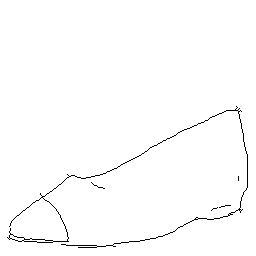

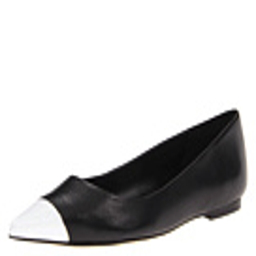

In [62]:
from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = (x.data.cpu().permute(1, 2, 0).numpy() + 1) * 255/2.0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

shoes, edges = next(iter(train_dataloader))
show(edges[0])
show(shoes[0])

In the next section you have to design and implement a generator and a discriminator model. Recall that the generator should map edge images (3x128x128 tensors) to shoe images (3x128x128 tensors), while the discriminator should map shoe, edge pairs (two 3x128x128 tensors) to a score.

In [71]:
# design your own Generator
#This is my final generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        )

        self.layer2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*2, momentum=0.1, eps=1e-5)
        )
        self.layer3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*4, momentum=0.1, eps=1e-5)
        )
        self.layer4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5)
        )
        self.layer5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5)
        )
        self.layer6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5)
        )
        self.layer7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5)
        )
        self.layer8 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1)
        )

        self.decoder_layer1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.Dropout2d(0.5, inplace=True)
        )
        self.decoder_layer2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.Dropout2d(0.5, inplace=True)
        )
        self.decoder_layer3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.Dropout2d(0.5, inplace=True)
        )
        self.decoder_layer4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*4, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*4, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*4*2, 64*2, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*2, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*2*2, 64*1, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*1, momentum=0.1, eps=1e-5)
        )

        self.decoder_layer8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*1*2, 3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )
    def forward(self, input):
        output1 = self.layer1(input)
        output2 = self.layer2(output1)
        output3 = self.layer3(output2)
        output4 = self.layer4(output3)
        output5 = self.layer5(output4)
        output6 = self.layer6(output5)
        output7 = self.layer7(output6)
        output8 = self.layer8(output7)
        
        decoder_output8 = self.decoder_layer1(output8)
        concat87 = torch.cat([decoder_output8, output7], 1)
        decoder_output7 = self.decoder_layer2(concat87)
        concat76 = torch.cat([decoder_output7, output6], 1)
        decoder_output6 = self.decoder_layer3(concat76)
        concat65 = torch.cat([decoder_output6, output5], 1)
        decoder_output5 = self.decoder_layer4(concat65)
        concat54 = torch.cat([decoder_output5, output4], 1)
        decoder_output4 = self.decoder_layer5(concat54)
        concat43 = torch.cat([decoder_output4, output3], 1)
        decoder_output3 = self.decoder_layer6(concat43)
        concat32 = torch.cat([decoder_output3, output2], 1)
        decoder_output2 = self.decoder_layer7(concat32)
        concat21 = torch.cat([decoder_output2, output1], 1)
        output = self.decoder_layer8(concat21)
        return output

In [56]:
#This generator is a scaled down version of the one above
#Please use the generator above and not this generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.1, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64*1, 64*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*2, momentum=0.1, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*4, momentum=0.1, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(64*8, 64*8, kernel_size=4, stride=2, padding=1),
        )

        self.decoder_layer2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.Dropout2d(0.5, inplace=True)
        )
        self.decoder_layer3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),
            nn.Dropout2d(0.5, inplace=True)
        )
        self.decoder_layer4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*8*2, 64*4, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*4, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*4*2, 64*2, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*2, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*2*2, 64*1, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*1, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*1*2, 64*1, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64*1, momentum=0.1, eps=1e-5)
        )
        self.decoder_layer8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64*1*2, 3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )
    def forward(self, input):
        output1 = self.layer1(input)
        output2 = self.layer2(output1)
        output3 = self.layer3(output2)
        output4 = self.layer4(output3)
        output5 = self.layer5(output4)
        output6 = self.layer6(output5)
        output7 = self.layer7(output6)
        #output8 = self.layer8(output7)
        #decoder_output8 = self.decoder_layer1(output8)
        #concat87 = torch.cat([decoder_output8, output7], 1)
        decoder_output7 = self.decoder_layer2(output7)
        concat76 = torch.cat([decoder_output7, output6], 1)
        decoder_output6 = self.decoder_layer3(concat76)
        concat65 = torch.cat([decoder_output6, output5], 1)
        decoder_output5 = self.decoder_layer4(concat65)
        concat54 = torch.cat([decoder_output5, output4], 1)
        decoder_output4 = self.decoder_layer5(concat54)
        concat43 = torch.cat([decoder_output4, output3], 1)
        decoder_output3 = self.decoder_layer6(concat43)
        concat32 = torch.cat([decoder_output3, output2], 1)
        decoder_output2 = self.decoder_layer7(concat32)
        concat21 = torch.cat([decoder_output2, output1], 1)
        output = self.decoder_layer8(concat21)
        return output

In [72]:
# design your own Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()   
        self.disc_seq = nn.Sequential(
           nn.Conv2d(3*2, 64, kernel_size=4, stride=2, padding=1),

           nn.LeakyReLU(0.2, inplace=True),
           nn.Conv2d(64, 64*2, kernel_size=4,stride=2, padding=1), 
           nn.BatchNorm2d(64*2, momentum=0.1, eps=1e-5),

           nn.LeakyReLU(0.2, inplace=True),
           nn.Conv2d(64*2, 64*4, kernel_size=4,stride=2, padding=1), 
           nn.BatchNorm2d(64*4, momentum=0.1, eps=1e-5),

           nn.LeakyReLU(0.2, inplace=True),    
           nn.Conv2d(64*4, 64*8, kernel_size=4,stride=1, padding=1), 
           nn.BatchNorm2d(64*8, momentum=0.1, eps=1e-5),

           nn.LeakyReLU(0.2, inplace=True), 
           nn.Conv2d(64*8, 1, kernel_size=4, stride=1, padding=1), 
           nn.Sigmoid()     
        )

    def forward(self, input):
        output = self.disc_seq(input)
        return output

Next you have to instantiate the losses that you will use to train the model. The pix2pix paper uses a reconstruction loss along with the standard GAN objective: in particular, the L1 reconstruction between (shoe, G(edge)) for a (shoe, edge) training pair, with the L1 loss being scaled up by a factor of 100 when adding to the GAN loss.

In [65]:
# instantiate losses
BCE = nn.BCELoss() #binary cross-entropy
L1 = nn.L1Loss() 

Instantiate models

In [73]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

and the necessary optimizers:

In [67]:
# instantiate optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

Finally, implement the GAN training objective below, where the discriminator is trained to distinguish real and fake pairs, while the generator is trained to fool the discriminator (and to also yield good reconstructions, in case you use a reconstruction term as in pix2pix).

In [75]:
# implement adversarial training for GANs
l1lambda = 100.0
for epoch in range(4):
    for i, (shoes, edges) in enumerate(train_dataloader):
        shoes = shoes.to('cuda')
        edges = edges.to('cuda')
        size = shoes.shape[0]
        real_labels = torch.ones(size,1,30, 30).to('cuda')
        fake_labels = torch.zeros(size,1,30, 30).to('cuda')

        #train discriminator!
        discriminator.zero_grad()
        #discriminator forward real images
        real_patch = discriminator(torch.cat([shoes,edges],dim=1))
        realGANloss = BCE(real_patch,real_labels)
        #discriminator forward fake images
        fake = generator(edges)
        fake_patch = discriminator(torch.cat([fake.detach(),edges],dim=1))
        fakeGANloss = BCE(fake_patch,fake_labels)
        discriminator_loss = realGANloss + fakeGANloss
        #Disc_optim.zero_grad()
        #back pass
        discriminator_loss.backward()
        #update discriminator
        discriminator_optimizer.step()

        #train generator!
        generator.zero_grad()
        fake_patch = discriminator(torch.cat([fake,edges],dim=1))
        fakeGANloss= BCE(fake_patch,real_labels)
        L1_loss = L1(fake,shoes)
        generator_loss = fakeGANloss + l1lambda*L1_loss
        #Gen_optim.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()

        if (i+1) % 500 == 0 :
          print('Epoch [{}/{}], Step [{}/{}], disc_loss: {:.4f}, gen_loss: {:.4f}, gen_loss_gan:{:.4f}, gen_loss_L1:{:.4f}'.format(epoch, 4, i+1, len(train_dataloader), discriminator_loss.item(), generator_loss.item(), fakeGANloss.item(), L1_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

Once the conditional GAN is trained, we can view how real and fake shoes look like for the same edge map in the validation set:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


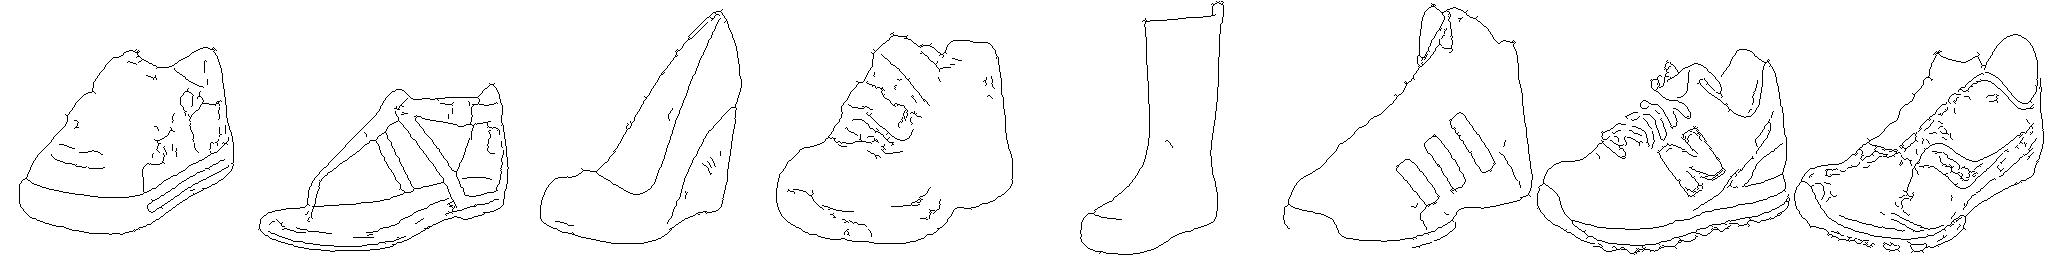

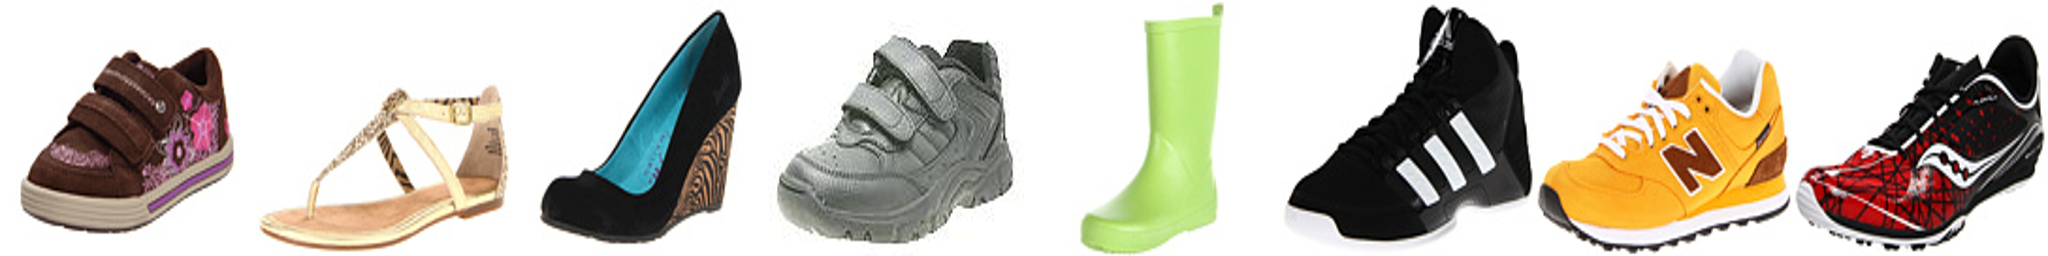

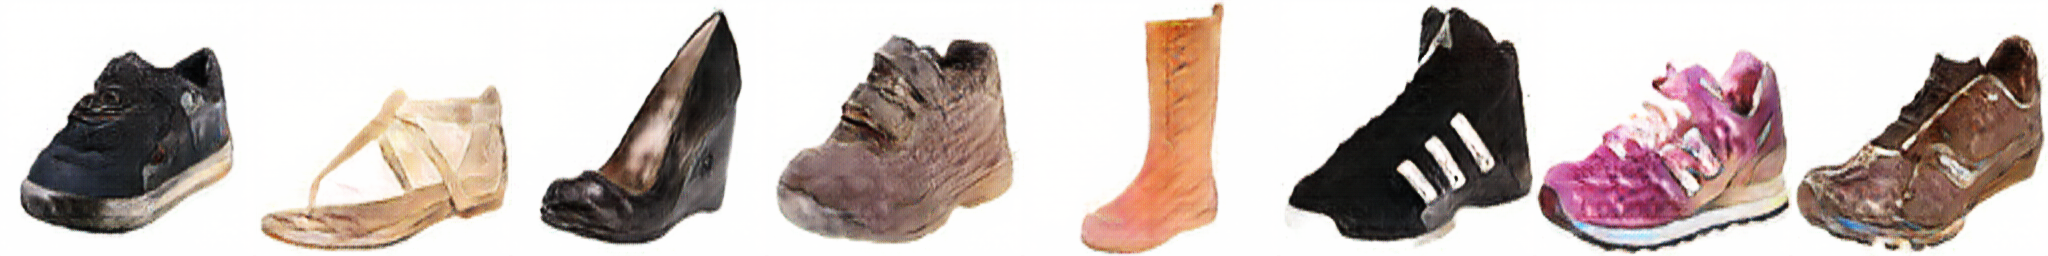

In [40]:
with torch.no_grad():
    shoes, edges = next(iter(val_dataloader))
    shoes, edges = shoes.cuda(), edges.cuda()
    fake_shoes = generator(edges)

    stacked_edges = torch.cat([edge for edge in edges[:8]], dim=2)
    stacked_shoes = torch.cat([shoe for shoe in shoes[:8]], dim=2)
    stacked_fake_shoes = torch.cat([fake_shoe for fake_shoe in fake_shoes[:8]], dim=2)

    show(stacked_edges)
    show(stacked_shoes)
    show(stacked_fake_shoes)

Finally, the cell below takes a subset of the training data and computes the FID (lower is better). A reasonable model should be able to achieve around 20 FID after a few training epochs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
os.chdir("/content")
import fid
eval_dataset = Edges2ShoesDataset("edges2shoes", "train")
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=True, num_workers=4)
print(fid.get_fid(eval_dataloader, generator))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


19.58677896594304
